In [1]:
from functools import partial
from pathlib import Path

from sklearn.model_selection import train_test_split

from imports_paper_plots import *

from echoes import ESNRegressor

from bioRNN.tasks.memory.capacity import make_X_y, forgetting
from bioRNN.utils import make_bioRRNs

set_context_and_font()
set_rcParams_color()

In [2]:
dir_res = Path(os.environ["DATAICNS"]) / "bioRNN"

In [3]:
task_name = "memory-capacity"
figs_path = Path(os.environ["DATAICNS"])/"bioRNN" /f"{task_name}/figs"

## Check ESN parameters for the task!

In [10]:
lags=np.arange(5, 101)
X, y = make_X_y(
    make_X=partial(np.random.uniform, low=-.5, high=.5, size=5_000),
    lags=lags,
    cut=0
)
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4000, 1), (1000, 1), (4000, 96), (1000, 96))

In [11]:
from sklearn.metrics import r2_score

In [12]:
def forgetting_R2(y_true, y_pred):
    assert y_pred.shape == y_true.shape, "y_pred and y_true must have same shape"
    assert y_pred.shape[0] > 1, "Error while computing forgetting: y_pred has less than 1 sample. Increase the number of samples (steps)"
    r2s = []
    for true, pred in zip(y_true.T, y_pred.T):        
        r2s.append(r2_score(true, pred))
    return r2s, np.sum(r2s)    

In [25]:
neuron_density = 100

CPU times: user 9min 27s, sys: 9.15 s, total: 9min 36s
Wall time: 2min 34s


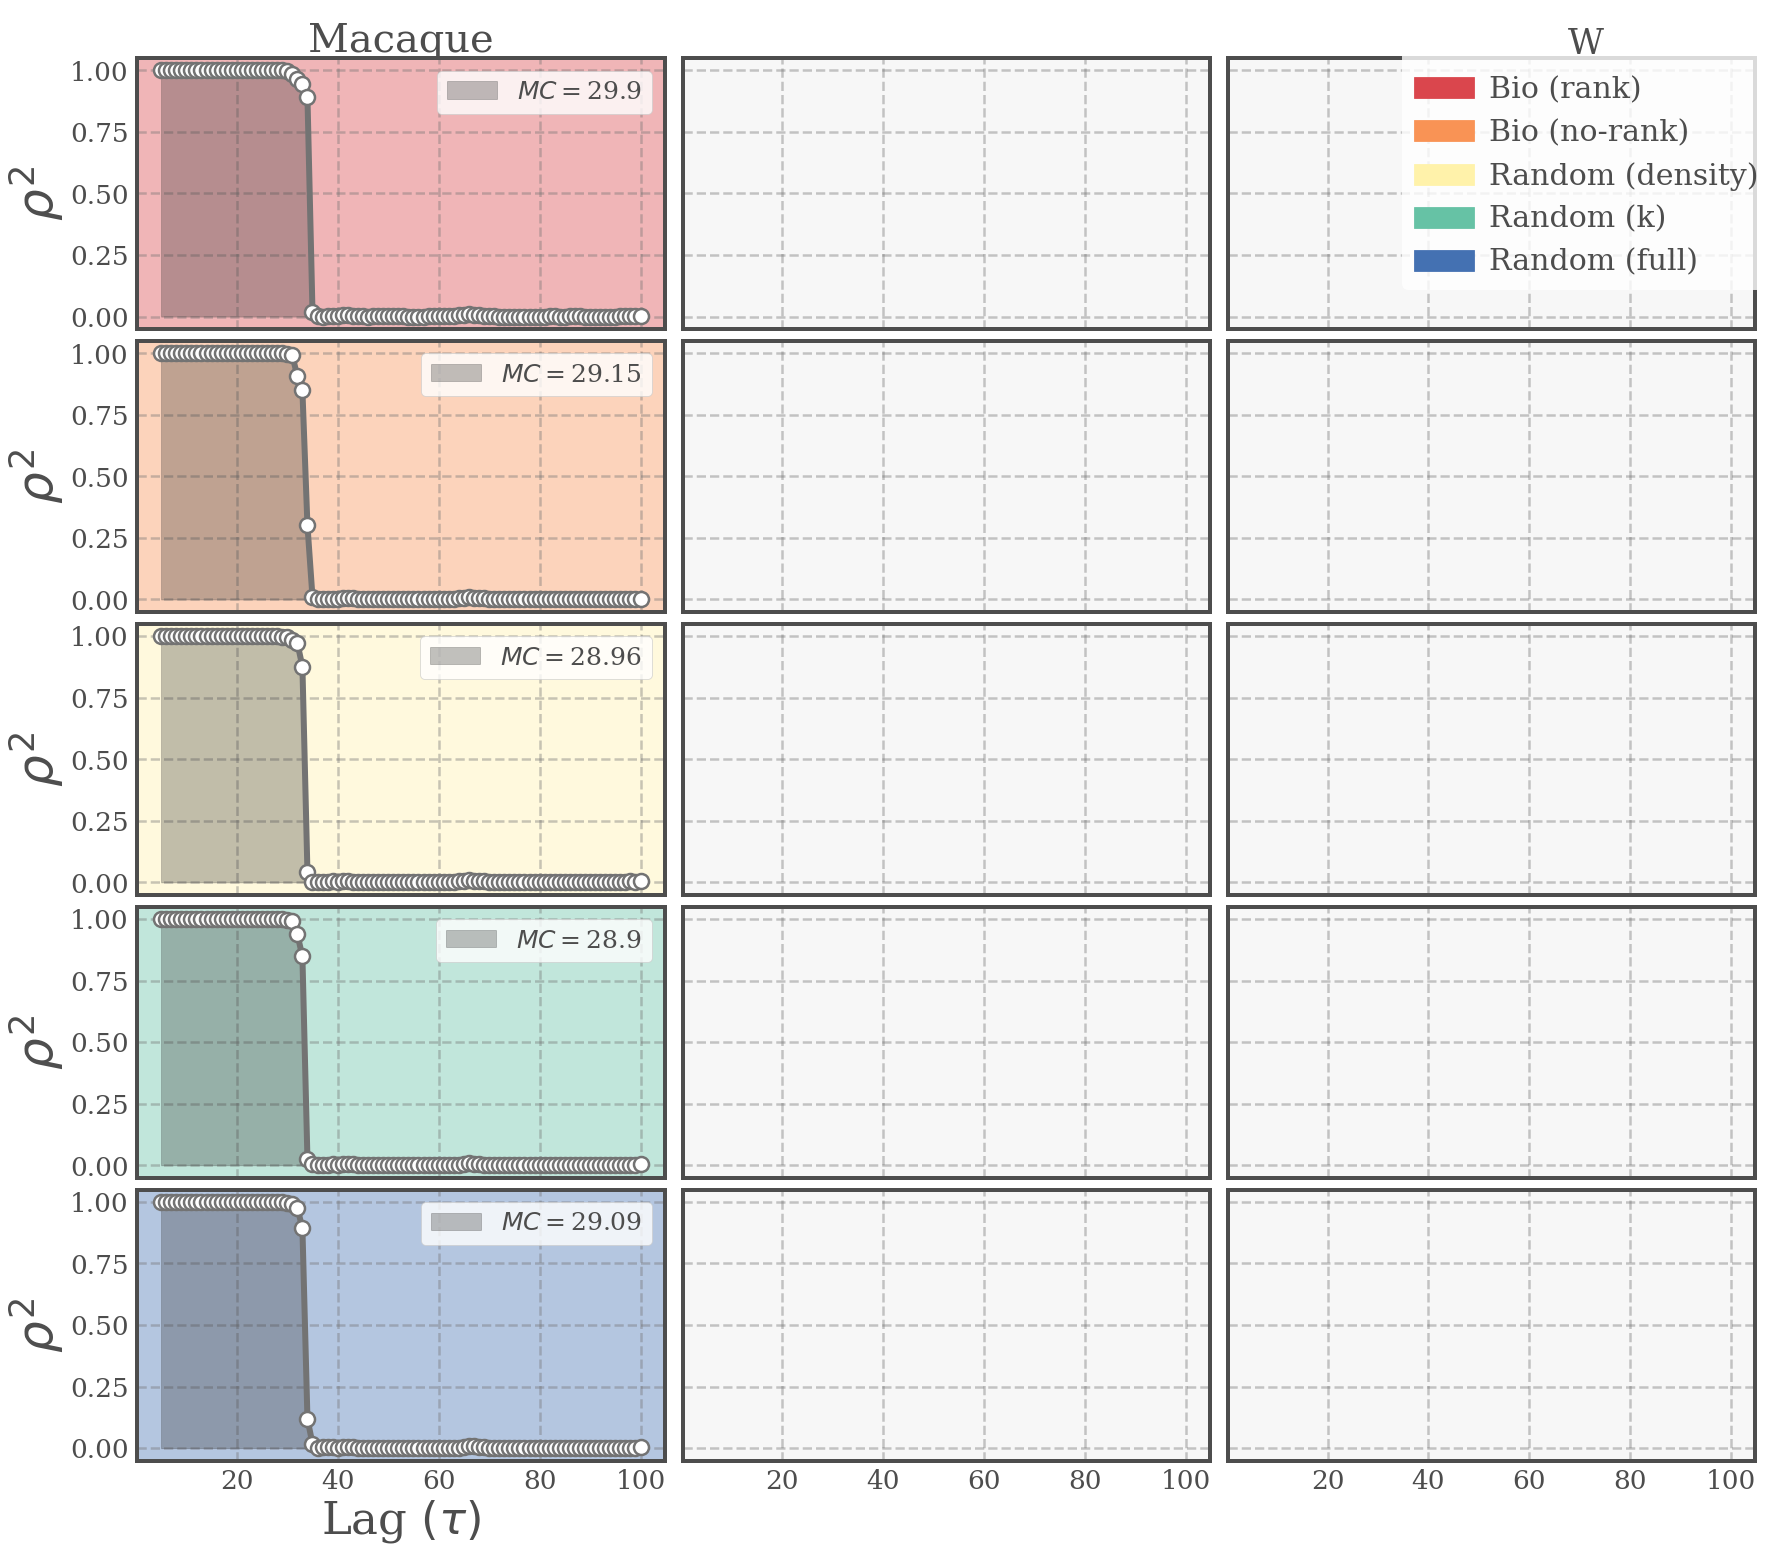

In [26]:
%%time
connectome_names = ["macaque",]# "marmoset", "human"]
n_transient = 100                                                              
background_alpha = .4
fill_alpha = .3
fill_color = ".2"

fig, axes = plt.subplots(nrows=5, ncols=3,
                         figsize=(25, 22),
                         sharey=True,
                         sharex=True,)

for col, connectome_name in enumerate(connectome_names):
    Ws = make_bioRRNs(connectome_name=connectome_name,
                      neuron_density=neuron_density,
                      rand_partition=True)

    background_colors = (c for c in my_palette)
    for row, (W_name, W) in enumerate(Ws.items()):
        y_pred = (ESNRegressor(W=W,
                               n_transient=n_transient, 
                               spectral_radius=.99,
                               input_scaling=1e-5,)
                  .fit(X_train, y_train)
                  .predict(X_test))
                  
        forget_curve, mc = forgetting(y_test[n_transient:], y_pred[n_transient:])
        forget_curve_2, mc2 = forgetting_R2(y_test[n_transient:], y_pred[n_transient:])
            
        # Plot
        current_color = next(background_colors)
        axes[row, col].plot(
            lags, 
            forget_curve, 
            color=grey, 
            linewidth=6, 
            linestyle="-", 
            markerfacecolor="white",
            markeredgecolor=grey,
            markersize=15,
            markeredgewidth=2.5,
            marker="o",
        )
        axes[row, col].fill_between(
            lags, 
            forget_curve, 
            color=fill_color,
            alpha=fill_alpha, 
            label=r"$MC = $" + f"{round(mc, 2)}"
        )
        axes[row, col].legend(loc=1, fontsize=25, facecolor="white")
        
        axes[row, col].set_facecolor(current_color)
        axes[row, col].patch.set_alpha(background_alpha)
        
        if col == 0:
            axes[row, col].set_ylabel(r"$\rho^{2}$", fontsize=50)
        if row == 0:
            axes[row, col].set_title(connectome_name.capitalize(), fontsize=40)
            
        if row == 4:
            axes[row, col].set_xlabel(r"Lag $(\tau)$", fontsize=45)
            
axes = np.array(fig.axes)
#set_spines_width(axes)
#remove_ticks(axes) 
tweak_axes(axes, grid_alpha=.4, grid_color=grey)
fig.legend(**make_legend_kwargs(Ws, my_palette, alpha=background_alpha*2.5))
fig.tight_layout(h_pad=0.2, w_pad=.4)

NameError: name 'forget_curve_3' is not defined

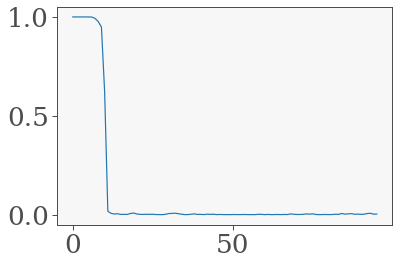

In [15]:
plt.plot(forget_curve)
plt.plot(forget_curve_3)

In [54]:
mc, mc2

(10.649902782816964, 10.302136865910333)